In [1]:
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import csv
import copy
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
dataset = stream.iter_csv(
            './data/bac_online_sample.csv',
            )

totallength = len(list(dataset))

In [3]:
dataset = stream.iter_csv(
            './data/bac_online_sample.csv',
            drop=['END_DATE','ROLE','CLOSURE_TYPE','CLOSURE_REASON','WORKING_STATE','case_cost'],
            target='outcome'
            )

**Event stream entry**  
----------  
**Example 1)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Service closure Request with network responsibility',  
  'START_DATE': '2018-10-10 12:48:12.000',  
  'CE_UO': '1'},  
 '')  
   
**Example 2)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Request completed with account closure',  
  'START_DATE': '2018-10-17 03:03:11.000',  
  'CE_UO': 'BOF'},  
 'False')

In [4]:
key_pair = {
        'REQUEST_ID':'caseid',
        'ACTIVITY':'activity',
        'START_DATE':'ts',
        'CE_UO':'resource'
}

case_dict ={}
training_models ={}
feature_matrix ={}
casecount = 0
rowcounter = 0
resultdict ={}
acc_dict ={}
running_case = 0
prediction_result = {}
graceperiod_finish=0
finishedcases = set()
usedingrace = set()

In [5]:
for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
#     progress = x['progress']

    x.pop('caseid')
    x.pop('outcome')
    
#     x.pop('progress')

    case_bin = prefix_bin(caseid, x)

    if caseid not in list(case_dict.keys()):
        case_bin.set_prefix_length(1)    
        case_dict[caseid] = []
    elif caseid in finishedcases:
        pass
    else:
        case_bin.set_prefix_length(len(case_dict[caseid])+1)
        case_bin.set_prev_enc(case_dict[caseid][-1])
    
    # Encode event and cases and add to DB
    case_bin.update_truelabel(outcome)   
    case_bin.update_encoded()
    ts = case_bin.event['ts']
    case_dict[caseid].append(case_bin)
    usedingrace.add(caseid)
    # Detect label appeared case 
    if outcome != '' and caseid not in finishedcases:
        finishedcases.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount <200:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    training_models['prefix_%s'%(prefix+1)] = [tree.HoeffdingTreeClassifier(grace_period=100,split_criterion='info_gain'),metrics.Accuracy(), 0,0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            graceperiod_finish = case_dict[caseid][-1].event['ts']
            for t in training_models.keys():
                training_models[t][3] = graceperiod_finish
            case_dict.pop(caseid)            
        else:
            break

0.0 % Case finished: 0
7.77 % Case finished: 12
15.55 % Case finished: 112
23.32 % Case finished: 184


In [6]:
maximum_prefix = sorted([int(x.split('_')[1]) for x in training_models.keys()])[-1]

In [7]:
case_dict ={}
for x,y in dataset:
    if rowcounter%3000 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running case: %s'%(running_case))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
    x.pop('caseid')
    x.pop('outcome')
    
    if caseid not in usedingrace:
        case_bin = prefix_bin(caseid, x)

        if caseid not in list(case_dict.keys()):
            case_bin.set_prefix_length(1)    
            case_dict[caseid] = []
            running_case +=1
        elif caseid in finishedcases:
            pass
        else:
            case_bin.set_prefix_length(len(case_dict[caseid])+1)
            case_bin.set_prev_enc(case_dict[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded()
        ts = case_bin.event['ts']
        if case_bin.prefix_length >=2 and case_bin.prefix_length <= maximum_prefix:
            case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
            x_test = case_bin.encoded
            model = training_models['prefix_%s'%(case_bin.prefix_length)][0]
            y_pred = model.predict_one(x_test)
            if type(y_pred) != str:
                y_pred = 'False'
            modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(case_bin.prefix_length)][2]), copy.deepcopy(y_pred)
            case_bin.update_prediction((modelid, (pred_value,ts)))        
        case_dict[caseid].append(case_bin)

        # Detect label appeared case 
        if outcome != '' and caseid not in finishedcases:
            finishedcases.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1    
            # Real training start

            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            if case_length >maximum_prefix:
                case_length =maximum_prefix
            y = outcome
            for prefix in range(1, case_length):
                case_dict[caseid][prefix].update_truelabel(y)
                x = case_dict[caseid][prefix].encoded
                model = training_models['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                training_models['prefix_%s'%(prefix+1)][2] +=1
                y_pred = model.predict_one(x)
                training_models['prefix_%s'%(prefix+1)][1].update(y,y_pred)

                for cases in list(case_dict.keys()):
                    if len(case_dict[cases]) >prefix:
                        x_test = case_dict[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(prefix+1)][2]), copy.deepcopy(y_pred)
                        case_dict[cases][prefix].update_prediction((modelid, (pred_value,ts)))
                        prediction_key = str(cases)+'_'+str(prefix+1)
                        if str(cases)+'_'+str(prefix+2) not in prediction_result.keys():
                            if prediction_key not in prediction_result.keys():
                                prediction_result[prediction_key] = {}
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
                            else:
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
#             print(case_dict[caseid][-2].predicted)
            copying = copy.deepcopy(case_dict[caseid])
            resultdict[caseid] = copying
            case_dict[caseid] =[]
            running_case -=1

            for prefix in training_models.keys():
                if prefix not in list(acc_dict.keys()):
                    acc_dict[prefix]=[training_models[prefix][1].get()]
                else:
                    acc_dict[prefix].append(training_models[prefix][1].get())


46.65 % Case finished: 354 Running case: 51
93.3 % Case finished: 804 Running case: 56


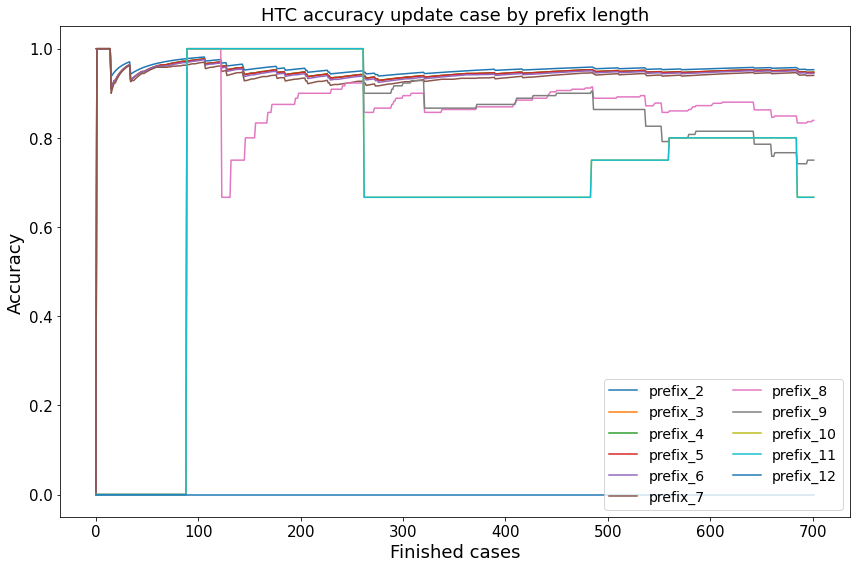

In [8]:

plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

for t in acc_dict.keys():
    plt.plot(acc_dict[t], label=str(t))
    plt.legend(ncol=2,loc='lower right')
plt.title('HTC accuracy update case by prefix length')
plt.ylabel('Accuracy')
plt.xlabel('Finished cases')
plt.tight_layout()
plt.savefig('./img/htc_acc_update.png')


In [9]:
# Continuous evaluation performance by relative time-event bin 

bin_n = 50
bin_event_acc = {}
y_true, target_pred = utils.rt_event_continuous_evaluation(resultdict, bin_n)
bin_event_acc = {}

for t in tqdm(range(2,12)):
    bin_y_true = []
    bin_y_pred = []
    if 'prefix_%s'%(t) not in list(bin_event_acc.keys()):
        bin_event_acc['prefix_%s'%(t)]=[]
    for prefix in y_true.keys():
        if t ==int(prefix.split('_')[1]):
            bin_y_true.append(y_true[prefix])
            bin_y_pred.append(target_pred[prefix])
#     print(bin_y_pred)
    for bin_interval in range(bin_n):
        bin_y_pred2 = [x[bin_interval] for x in bin_y_pred]
        bin_event_acc['prefix_%s'%(t)].append(accuracy_score(bin_y_true, bin_y_pred2))

 40%|████      | 4/10 [00:00<00:00, 32.66it/s]/home/suhwan/.conda/envs/testenv/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/suhwan/.conda/envs/testenv/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [00:00<00:00, 51.69it/s]


In [22]:
# Continuous evaluation performance by prefix length-case bin 

y_true, target_pred = utils.pl_case_continuous_evaluation(resultdict)
bin_event_acc = {}
max_length = max([len(x) for x in resultdict])
print(max_length)
for t in tqdm(range(2,13)):
    bin_y_true = []
    bin_y_pred = []
    if 'prefix_%s'%(t) not in list(bin_event_acc.keys()):
        bin_event_acc['prefix_%s'%(t)]=0
        
    for prefix in y_true.keys():
        if t ==int(prefix.split('_')[1]):
            bin_y_true.append(y_true[prefix])
            bin_y_pred.append(target_pred[prefix])
            bin_event_acc['prefix_%s'%(t)]= accuracy_score(bin_y_true, bin_y_pred)

  0%|          | 0/11 [00:00<?, ?it/s]

12


100%|██████████| 11/11 [00:01<00:00, 10.76it/s]


In [72]:
def rt_case_continuous_evaluation(resultdict, bin_n):
    bin_pred = {}
    y_true = {}
    for case in tqdm(resultdict.keys()):
        if len(resultdict[case]) > 2:
            prediction_counter = 0
            prediction_by_bin ={}
            start_ts = resultdict[case][1].event['ts']
            end_ts = resultdict[case][-1].event['ts']
            bin_list = utils.get_ts_bin_list(start_ts, end_ts, bin_n)
            for event in range(1,len(resultdict[case])-1):
                for predict in resultdict[case][event].predicted.keys():
                    prediction_by_bin[prediction_counter] = resultdict[case][event].predicted[predict]
                    prediction_counter +=1
            t = utils.ts_averaged_prediction_by_bin(bin_list,prediction_by_bin)
            for each_bin in [x for x in t.keys()]:                
                y_true[str(case)+'_'+str(each_bin[2]+1)]=resultdict[case][event].true_label
                bin_pred[str(case)+'_'+str(each_bin[2]+1)]= t[each_bin]

#                 y_true[str(case)+'_'+str(event+1)] = resultdict[case][event].true_label
#                 bin_pred[str(case)+'_'+str(event+1)] = averaged_prediction(bin_result_list)
            
    return y_true, bin_pred

In [84]:
# Continuous evaluation performance by relative time-case bin 

bin_n = 50
bin_event_acc = {}
y_true, target_pred = rt_case_continuous_evaluation(resultdict, bin_n)

for t in tqdm(range(1,51)):
    bin_y_true = []
    bin_y_pred = []
    if 'Bin_%s'%(t) not in list(bin_event_acc.keys()):
        bin_event_acc['Bin_%s'%(t)]=0
        
    for prefix in y_true.keys():
        if t ==int(prefix.split('_')[1]):
            bin_y_true.append(y_true[prefix])
            bin_y_pred.append(target_pred[prefix])
            bin_event_acc['Bin_%s'%(t)]= accuracy_score(bin_y_true, bin_y_pred)

100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


[0.9472, 0.9529914529914529]
[0.9471153846153846, 0.9472]
[0.9470304975922953, 0.9471153846153846]
[0.9447236180904522, 0.9470304975922953]
[0.9400749063670412, 0.9447236180904522]
[0.8392857142857143, 0.9400749063670412]
[0.71875, 0.8392857142857143]
[0.6666666666666666, 0.75]
[0.6666666666666666, 0.6666666666666666]
[0.05, 0.6666666666666666]
[0.05, 0.05]


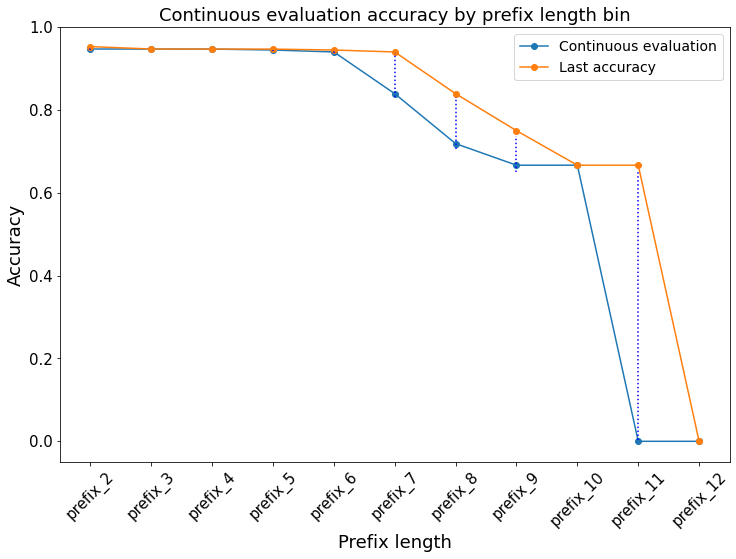

In [23]:
plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

axes = plt.gca()
axes.set_ylim([-0.05, 1.0])
x,ce_acc_y = list(bin_event_acc.keys()),[bin_event_acc[x] for x in bin_event_acc.keys()]
last_acc_y = [acc_dict[x][-1] for x in acc_dict.keys()]
plt.plot(x,ce_acc_y,'-o',label='Continuous evaluation')
plt.plot(x,last_acc_y, '-o',label = 'Last accuracy')

y_gap = [[t, last_acc_y[pos]] if t<= last_acc_y[pos] else (last_acc_y[pos], t) for pos,t in enumerate(ce_acc_y) ]
for pos in range(len(y_gap)):
    if y_gap[pos][0] ==0:
        y_gap[pos][0] = 0.05
    if y_gap[pos][1] ==0:
        y_gap[pos][1] = 0.05
plt.title('Continuous evaluation accuracy by prefix length bin')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Prefix length')
plt.xticks(rotation='45')

for gap in range(len(y_gap)):
    print(y_gap[gap])
    plt.axvline(x=gap, ymin= y_gap[gap][0], ymax = y_gap[gap][1],color='b',ls=':', label='axvline - full height')
    

# plt.savefig('./img/HTC continuous acc.png')

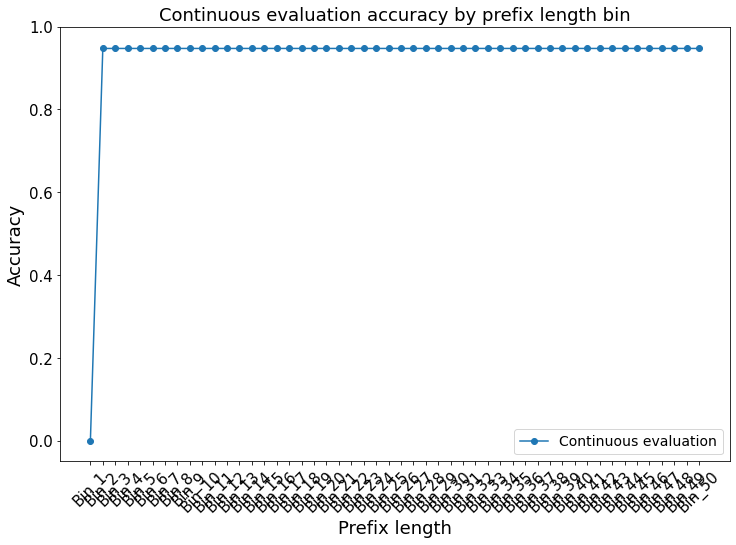

In [85]:
plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

axes = plt.gca()
axes.set_ylim([-0.05, 1.0])
x,ce_acc_y = list(bin_event_acc.keys()),[bin_event_acc[x] for x in bin_event_acc.keys()]
plt.plot(x,ce_acc_y,'-o',label='Continuous evaluation')
# plt.plot(x,last_acc_y, '-o',label = 'Last accuracy')

plt.title('Continuous evaluation accuracy by prefix length bin')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Prefix length')
plt.xticks(rotation='45')
    
plt.show()
# plt.savefig('./img/HTC continuous acc.png')

In [13]:
import pickle as pkl
uio = []
for t in acc_dict.keys():
    uio.append(t)
y = [acc_dict[x][-1] for x in acc_dict.keys()]
with open('./result/htc_lastacc.pkl','wb') as f:
    pkl.dump([uio,y],f)